<a href="https://colab.research.google.com/github/SuriyaG09/Customer_Churn_analysis_in_Telecom/blob/main/Customer_Churn_analysis_in_Telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Telecom Customer Churn:

 Attributes in the dataset : customerID, gender, SeniorCitizen,	Partner,	Dependents,	tenure,	PhoneService,	MultipleLines,InternetService,	OnlineSecurity,	OnlineBackup,	DeviceProtection,	TechSupport,	StreamingTV,	StreamingMovies,	Contract,	PaperlessBilling,	PaymentMethod,	MonthlyCharges,	TotalCharges,	Churn

   
   Dataset is taken from Kaggle

In [1]:
# Importing neccessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectKBest
from collections import Counter

# ignore warning
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick # for showing percentage in it

In [2]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Features types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

From analysis of the dataset:

I noticed that some independent features are in numerical and most of feature are in categorical feature. Seperate into numerical and categorical data.

In [4]:
# Total charges are in object dtype so convert into Numerical feature
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#### Separate into Numerical and Categorical feature

In [6]:
numerical_feature = {feature for feature in df.columns if df[feature].dtypes != 'O'}
print(f'Count of Numerical feature: {len(numerical_feature)}')
print(numerical_feature)

Count of Numerical feature: 4
{'MonthlyCharges', 'tenure', 'SeniorCitizen', 'TotalCharges'}


In [7]:
categorical_feature = {feature for feature in df.columns if df[feature].dtypes == 'O'}
print(f'Count of Categorical feature: {len(categorical_feature)}')
print(categorical_feature)

Count of Categorical feature: 17
{'customerID', 'Dependents', 'PaymentMethod', 'OnlineSecurity', 'TechSupport', 'Churn', 'StreamingMovies', 'Partner', 'InternetService', 'OnlineBackup', 'PhoneService', 'DeviceProtection', 'StreamingTV', 'gender', 'PaperlessBilling', 'MultipleLines', 'Contract'}


## Preliminary insights from the data

In [14]:
print("Count of Churn = ",df['Churn'].value_counts()['Yes'], "\nCount of non-churn = ",df['Churn'].value_counts()['No'])

Count of Churn =  1869 
Count of non-churn =  5174


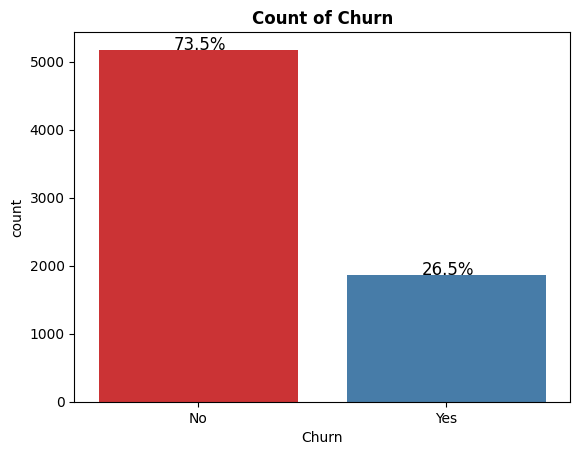

In [21]:
# Create a count plot using seaborn

color_palette = 'Set1'
ax = sns.countplot(data=df, x='Churn',palette=color_palette)

# Add a title to the plot
plt.title('Count of Churn', fontweight='bold')

# Calculate the percentage for each category
total = len(df['Churn'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=12)

# Show the plot
plt.show()


- key insight: 1869 customers left the service. Which is about 26.5 percentage from overall, this like an imbalance dataset

In [26]:
loss = []
for values in df.loc[df['Churn'] == 'Yes', 'TotalCharges']:
    value = float(values)
    loss.append(value)
print("Loss because of the left churns: ",np.round(sum(loss)))

Loss because of the left churns:  2862927.0


**We have lost arround $2862927 due to customer churn**

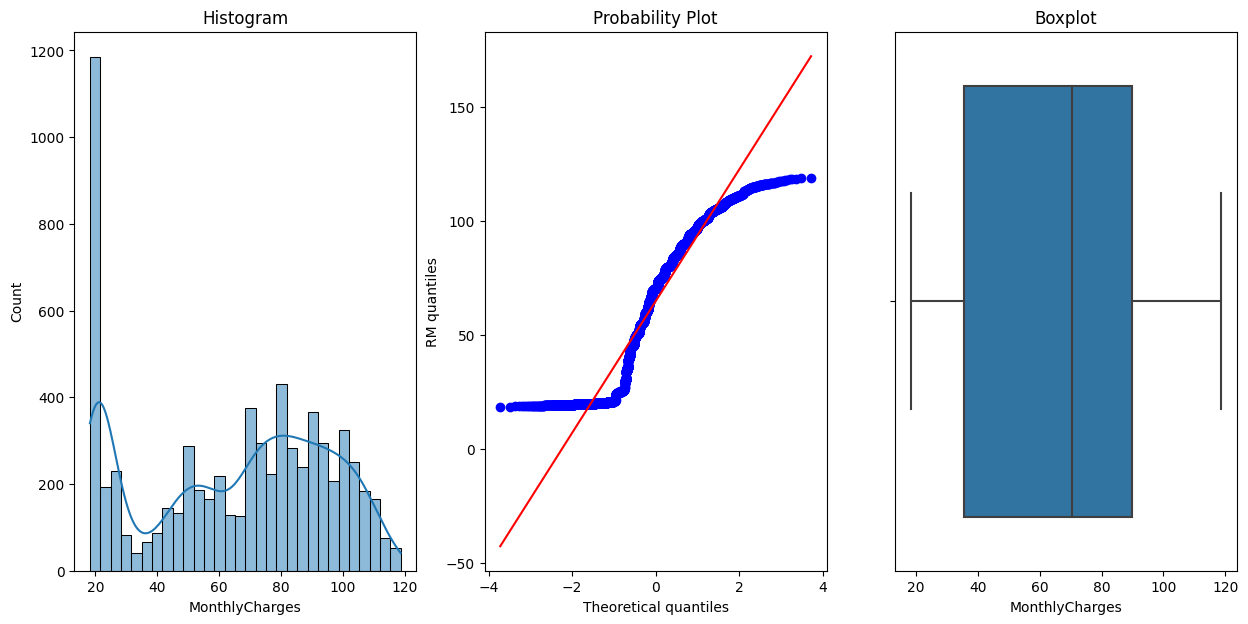

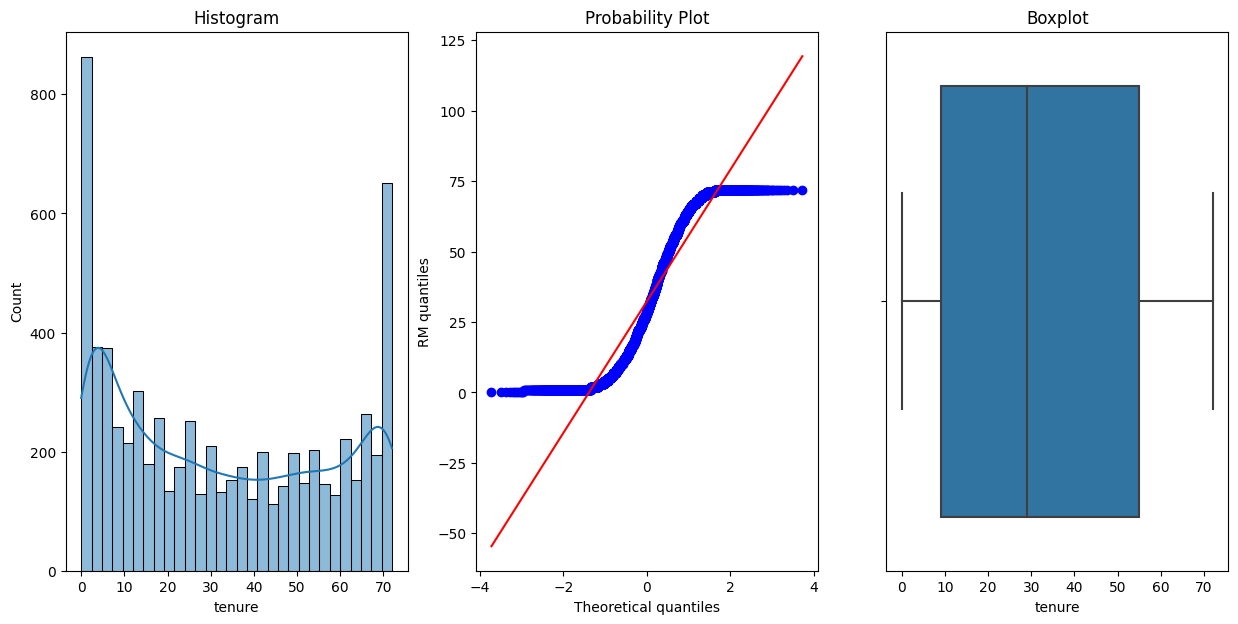

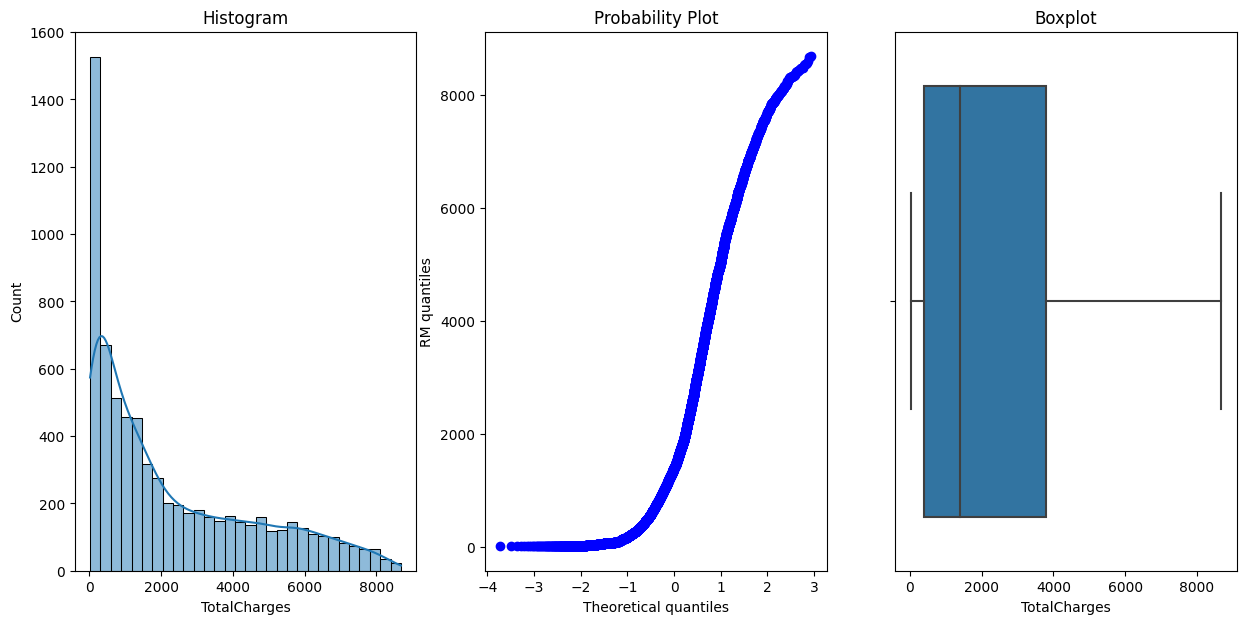

In [28]:
### Plotting numerical feature with probability distribution and checking outlier
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(15,7))

        plt.subplot(1, 3, 1)
        sns.histplot(data=df, x=feature, bins=30, kde=True)
        plt.title('Histogram')

        plt.subplot(1, 3, 2)
        stats.probplot(df[feature], dist="norm", plot=plt)
        plt.ylabel('RM quantiles')

        plt.subplot(1, 3, 3)
        sns.boxplot(x=df[feature])
        plt.title('Boxplot')

plt.show()

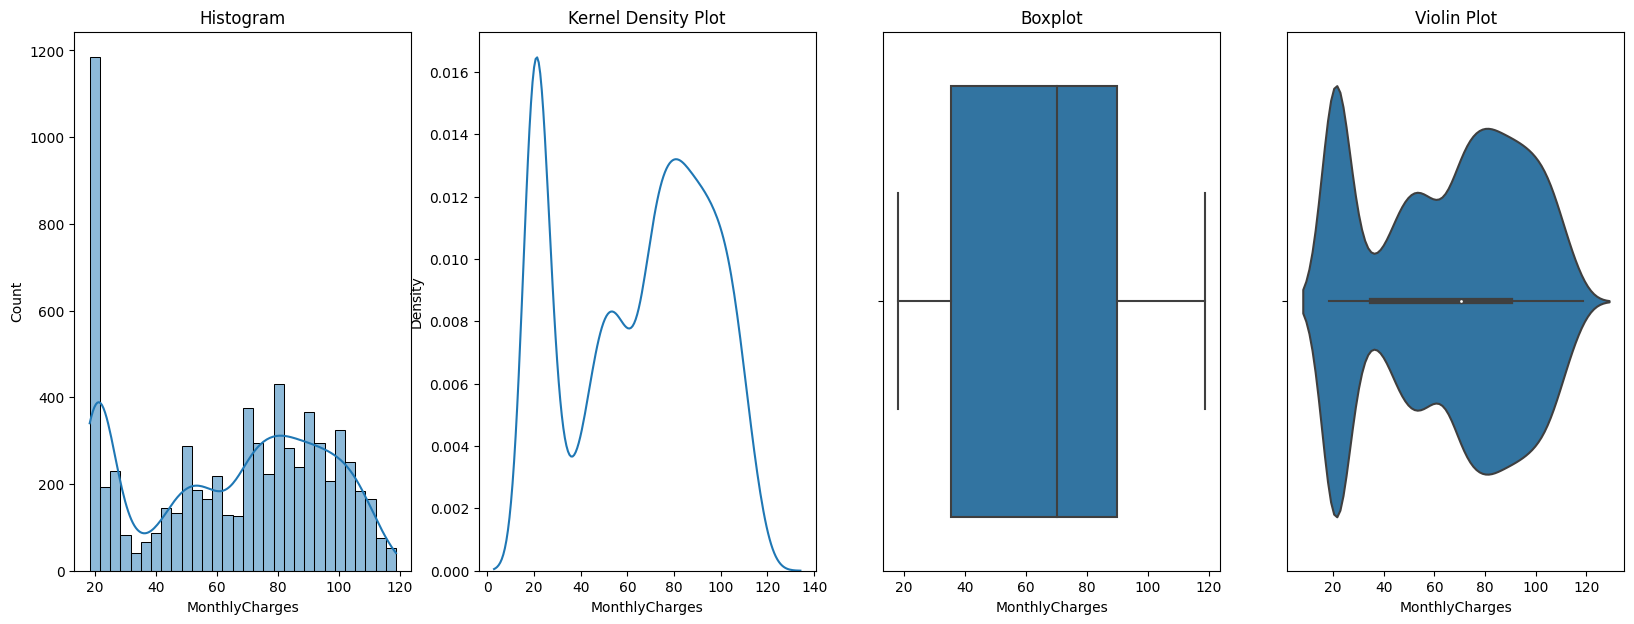

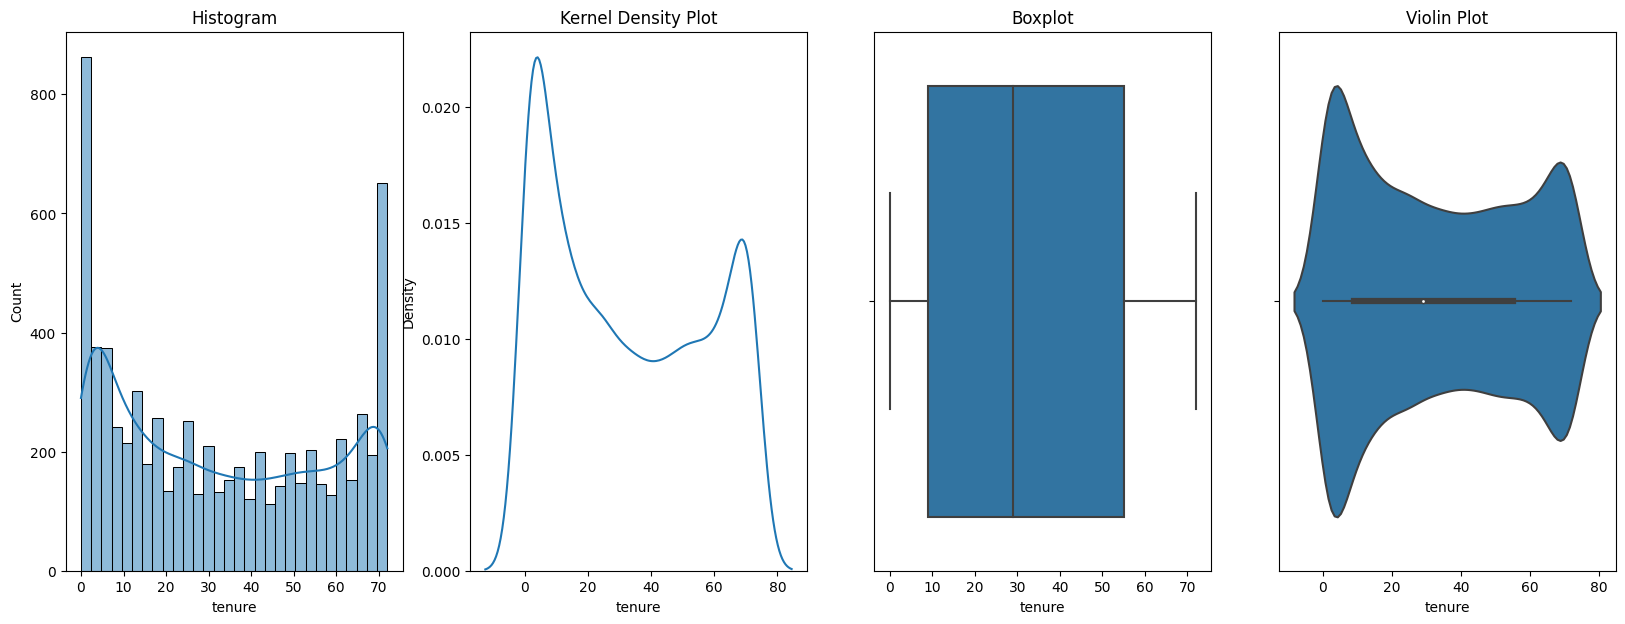

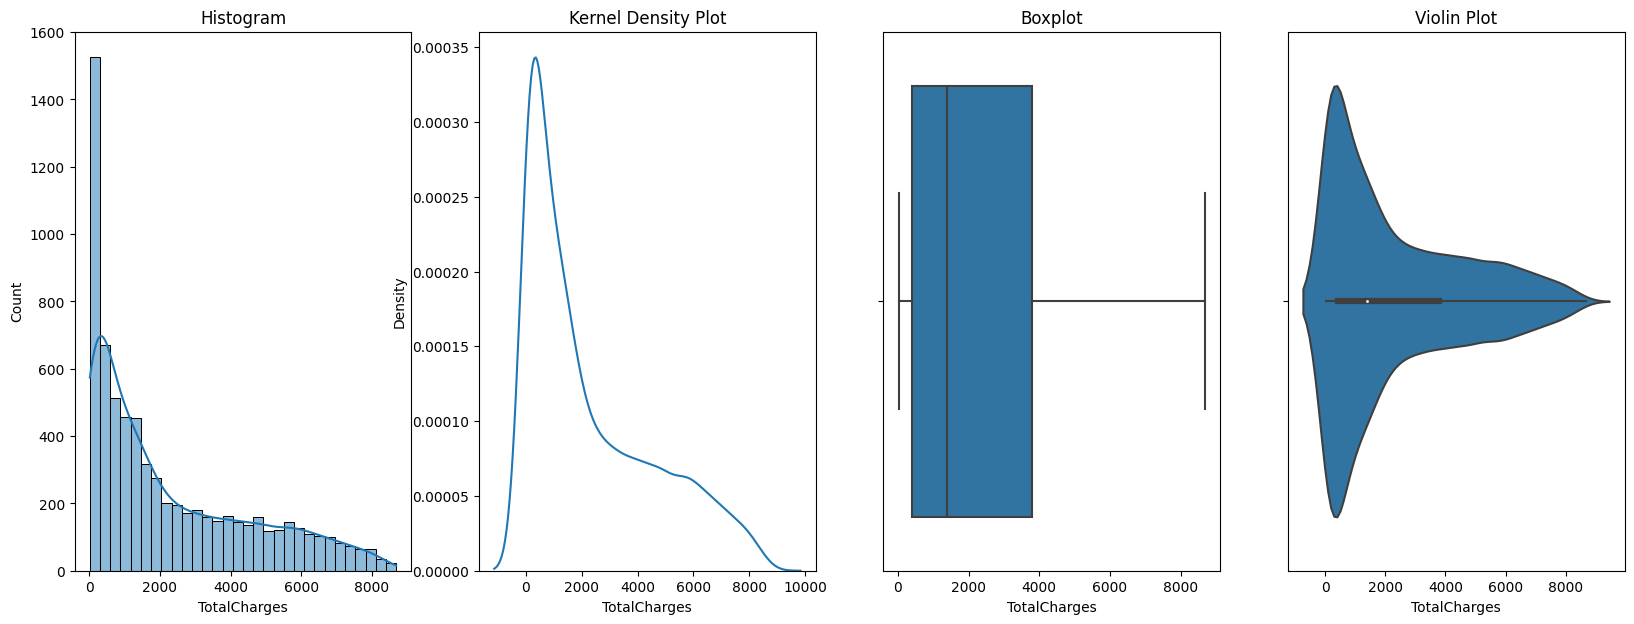

In [29]:
for feature in numerical_feature:
    if feature != 'SeniorCitizen':
        plt.figure(figsize=(20, 7))

        plt.subplot(1, 4, 1)
        sns.histplot(data=df, x=feature, bins=30, kde=True)
        plt.title('Histogram')

        plt.subplot(1, 4, 2)
        sns.kdeplot(data=df, x=feature)
        plt.title('Kernel Density Plot')

        plt.subplot(1, 4, 3)
        sns.boxplot(x=df[feature])
        plt.title('Boxplot')

        plt.subplot(1, 4, 4)
        sns.violinplot(x=df[feature])
        plt.title('Violin Plot')

        plt.show()


- key insight is that we don't have any outliers

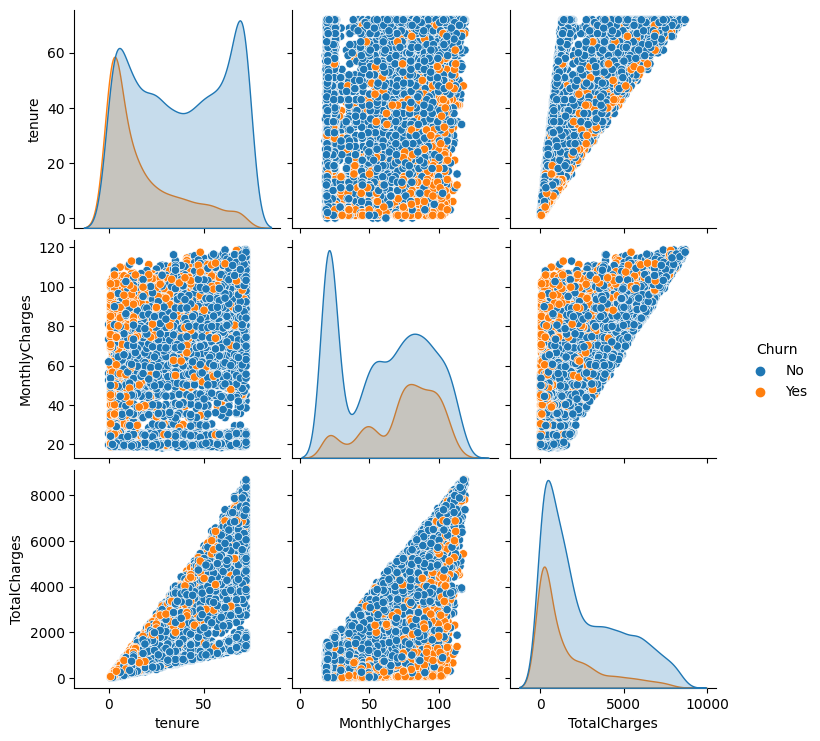

In [30]:
sns.pairplot(df.drop(columns='SeniorCitizen'),hue='Churn', kind='scatter')
plt.show()

Text(0.5, 1.0, 'Percentage of Senior Citizens')

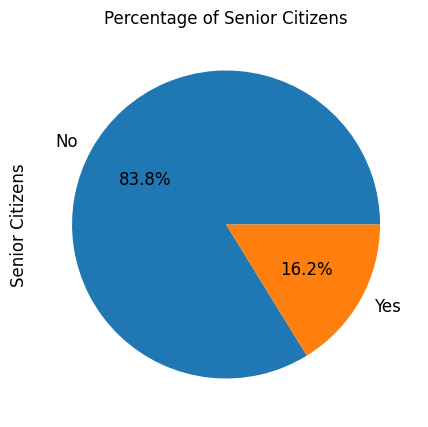

In [34]:
ax = (df['SeniorCitizen'].value_counts()*100.0 /len(df)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('Percentage of Senior Citizens', fontsize = 12)

Only 16.2% customers who are senior citizons but remaining 83.8% customers are young people

#### **Univariate Analysis:**

<Figure size 640x480 with 0 Axes>

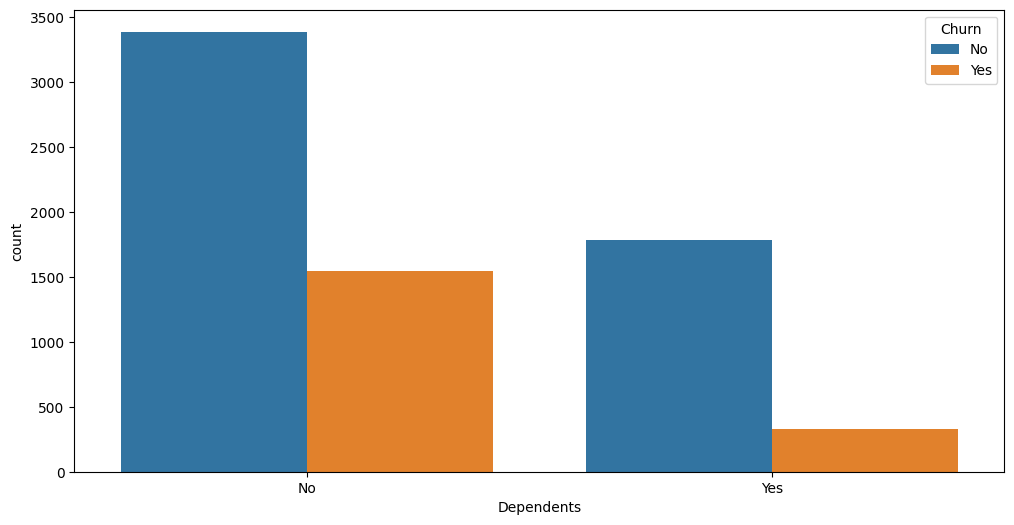

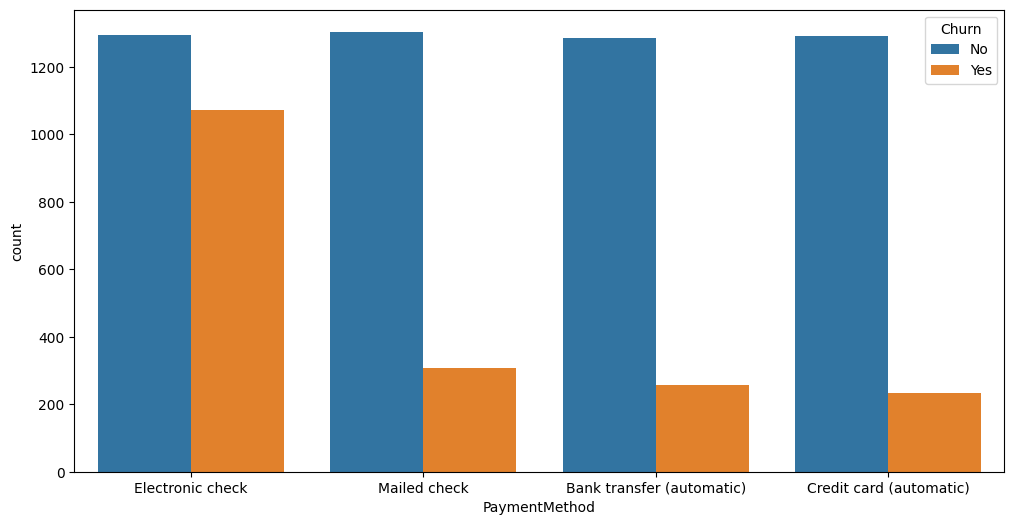

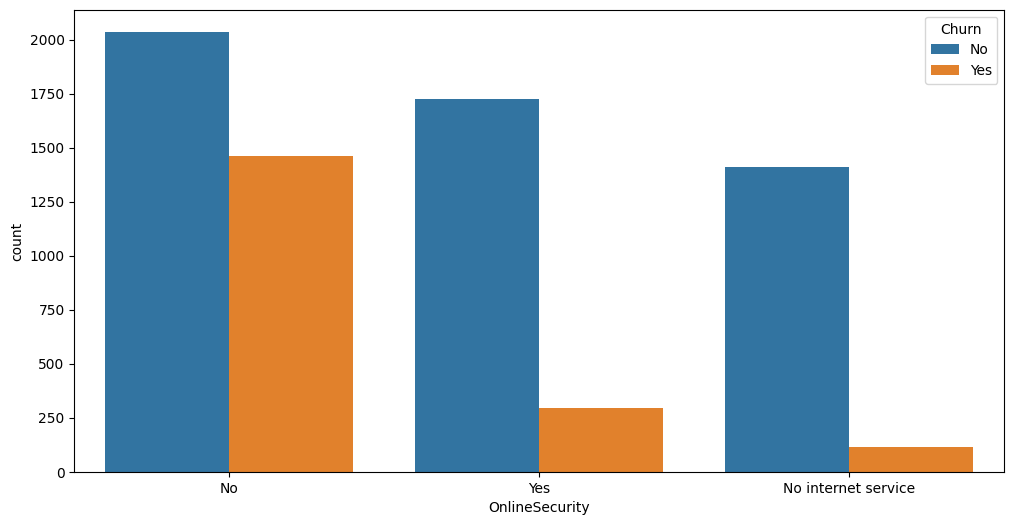

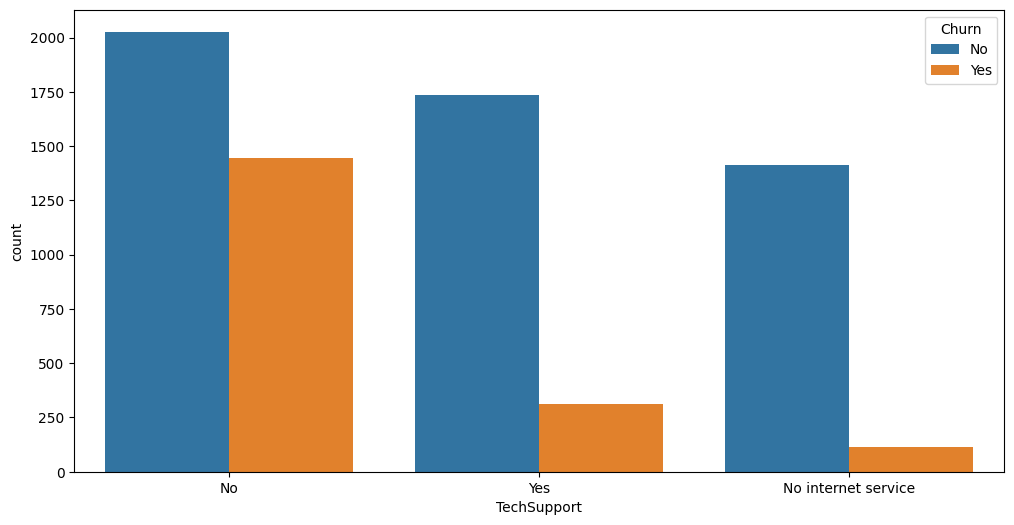

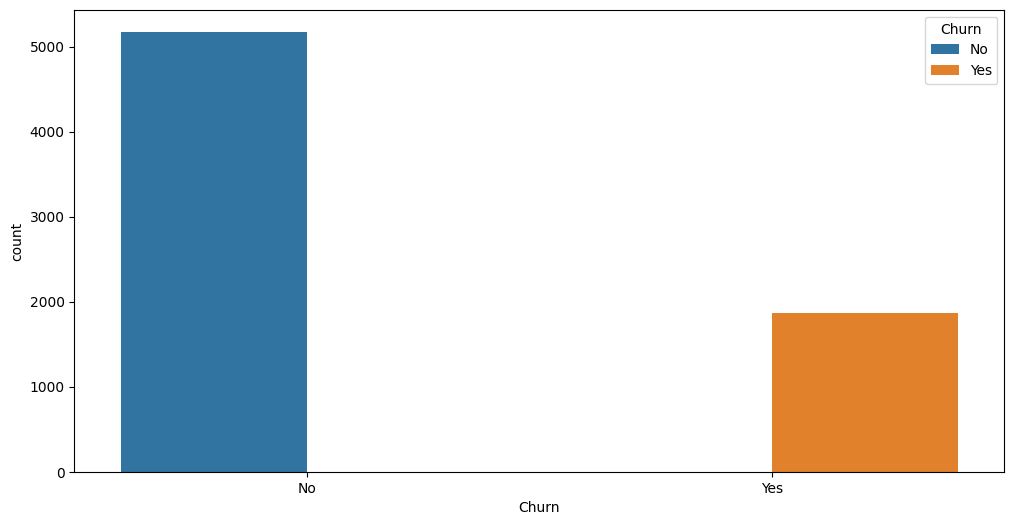

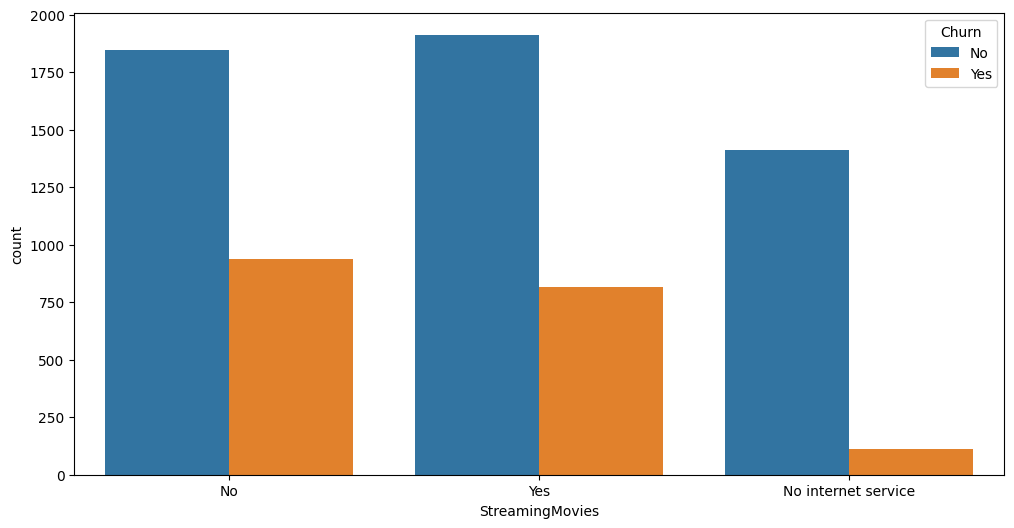

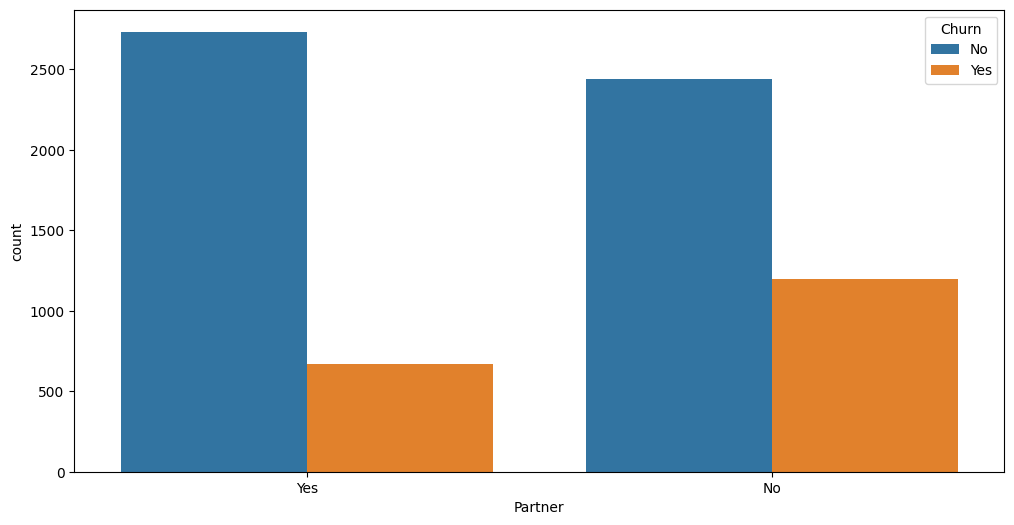

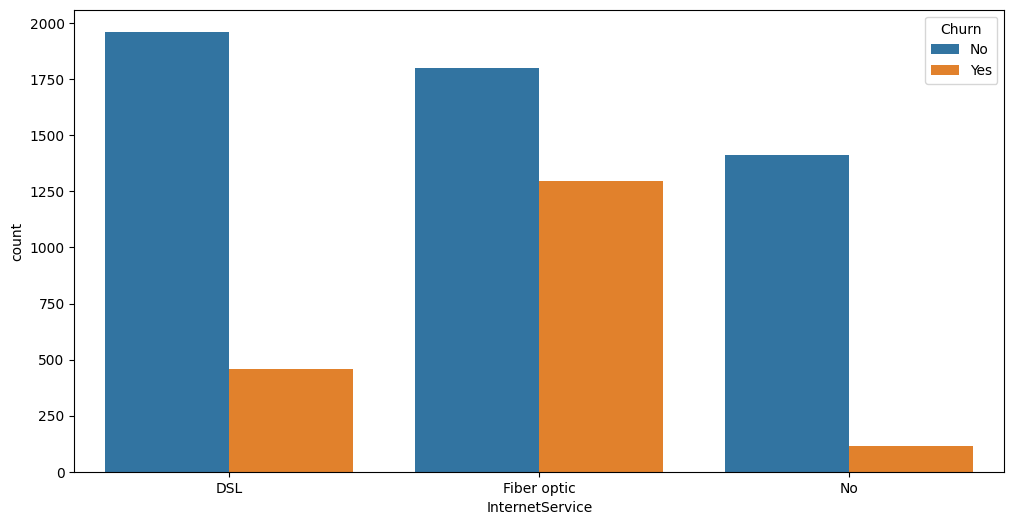

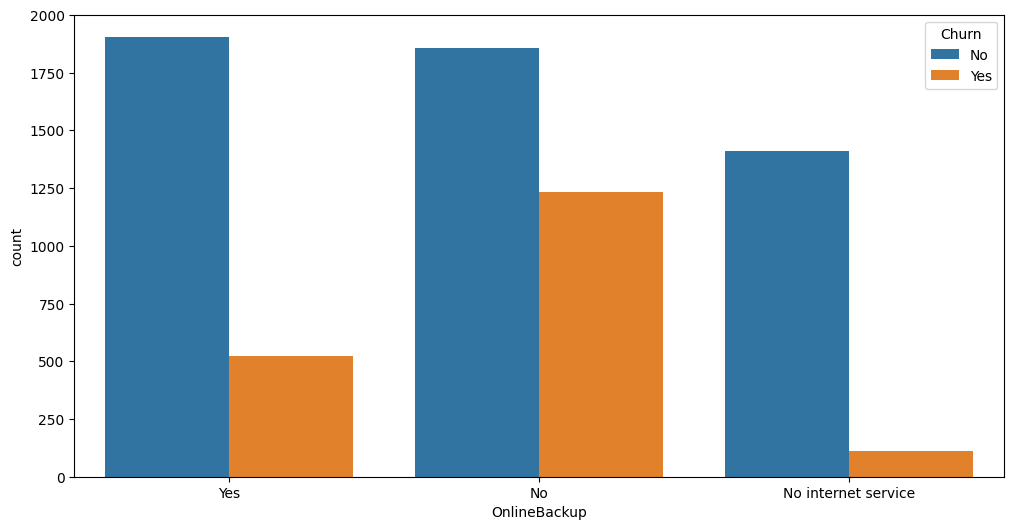

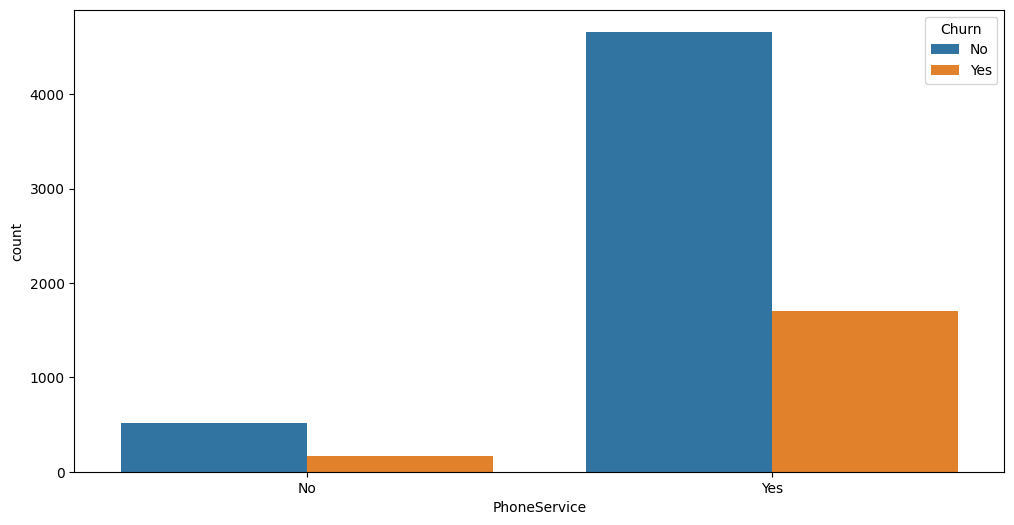

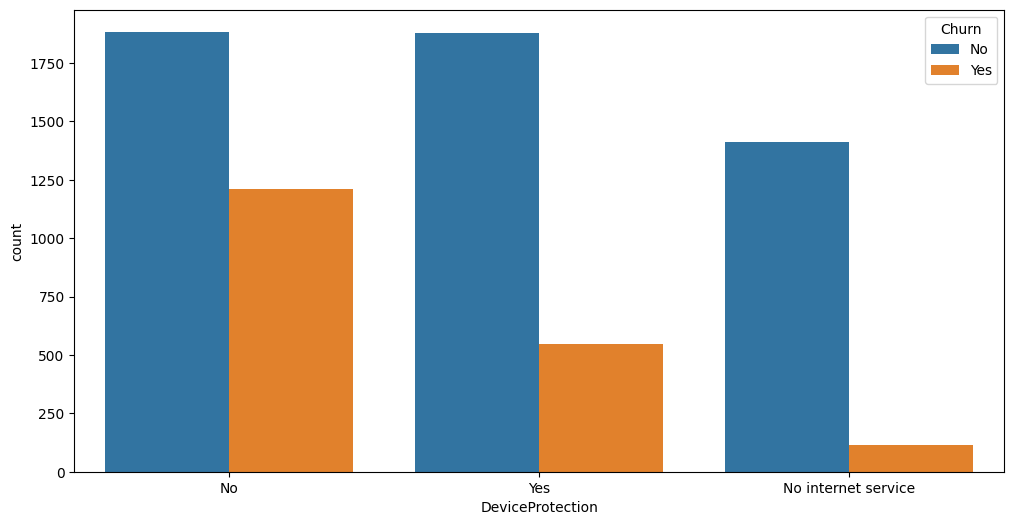

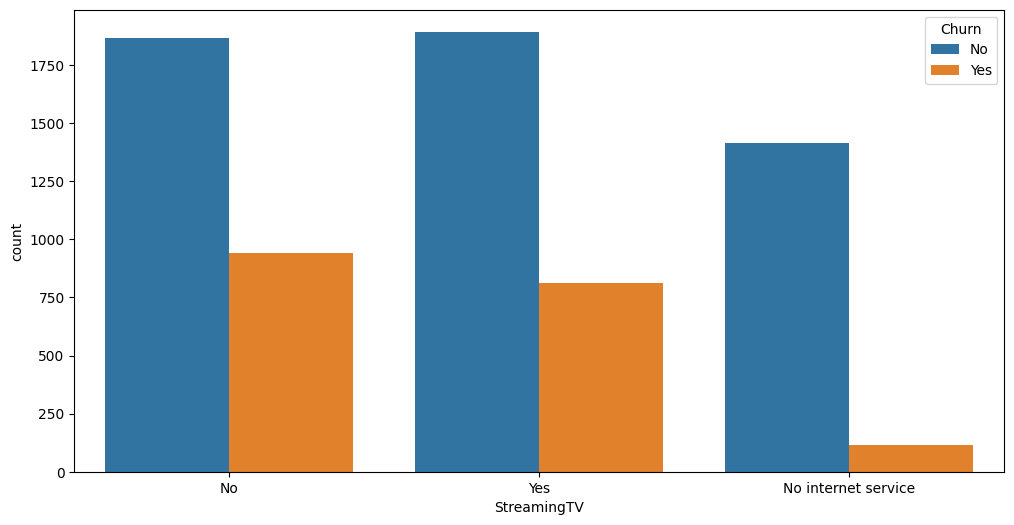

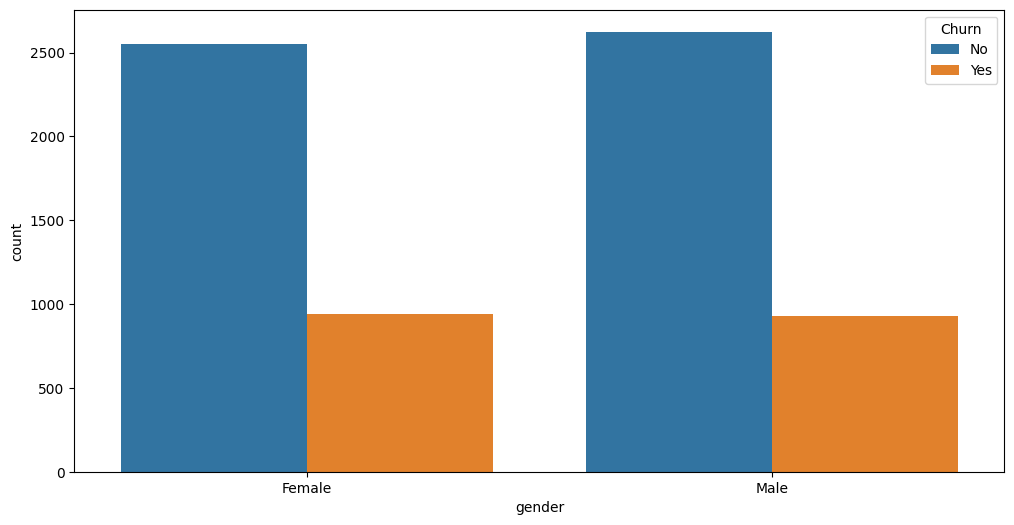

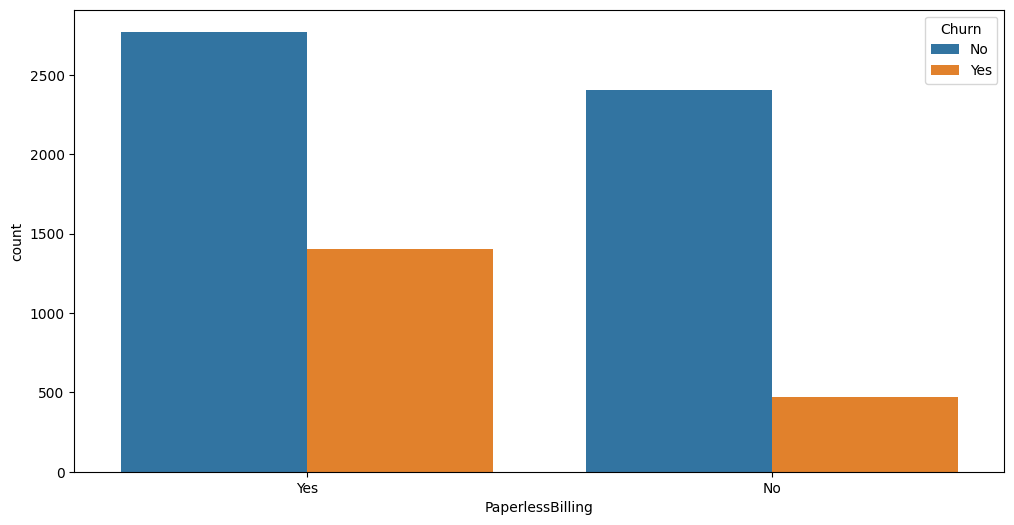

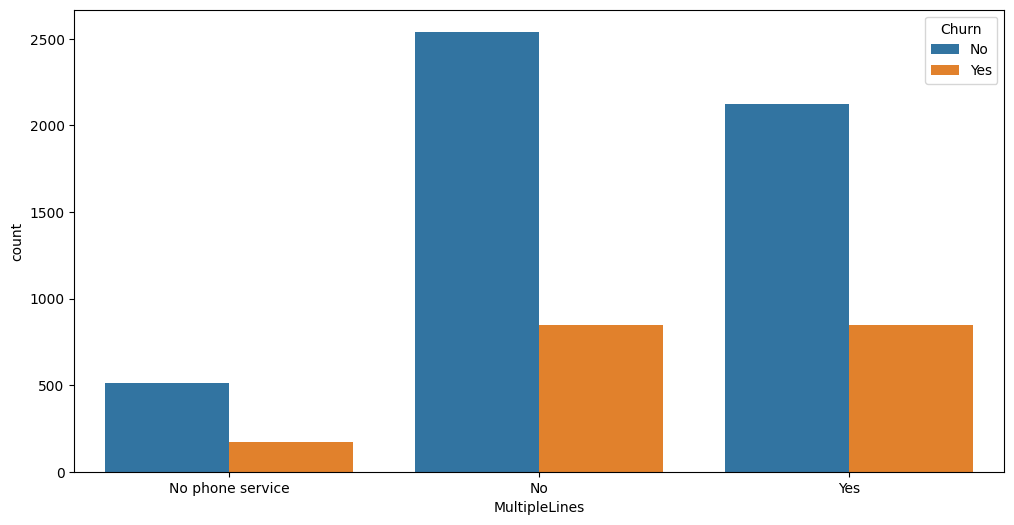

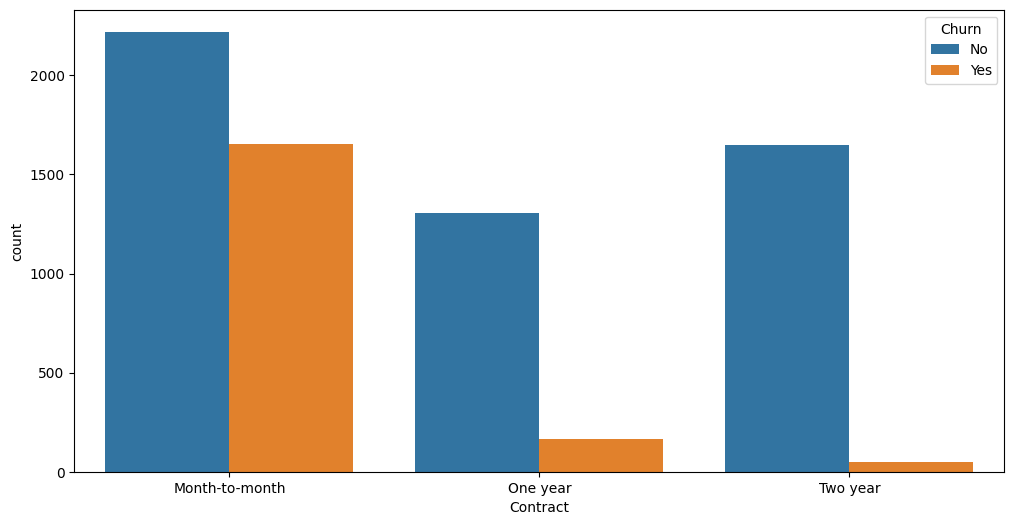

In [37]:
for i, feature in enumerate(categorical_feature):
    if feature != 'TotalCharges':
        if feature != 'customerID':
            plt.figure(i)
            plt.figure(figsize=(12,6))
            sns.countplot(data=df, x=feature, hue='Churn')
plt.show()

#### **Data Cleaning:**

In [38]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [40]:
# replace NaN values with median value
df.TotalCharges = df.TotalCharges.fillna(df.TotalCharges.median())

<Axes: >

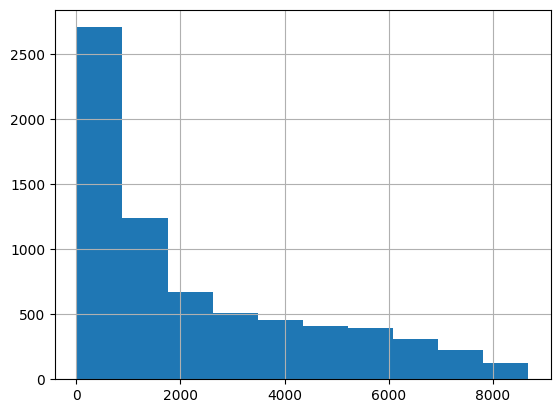

In [41]:
df.TotalCharges.hist()

Now the dataset do not have null values, so no need for to perform Handling missing values. Only perform the Feature Encoding techiniques to convert the categorical feature into numerical feature

In [42]:
print(categorical_feature)

{'customerID', 'Dependents', 'PaymentMethod', 'OnlineSecurity', 'TechSupport', 'Churn', 'StreamingMovies', 'Partner', 'InternetService', 'OnlineBackup', 'PhoneService', 'DeviceProtection', 'StreamingTV', 'gender', 'PaperlessBilling', 'MultipleLines', 'Contract'}


In [43]:
encoder = LabelEncoder()
for feature in categorical_feature:
    df[feature] = encoder.fit_transform(df[feature])

In [44]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5375,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3962,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2564,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5535,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6511,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [45]:
df.drop(columns=['customerID'], inplace=True)

Correlation of churn

<Axes: >

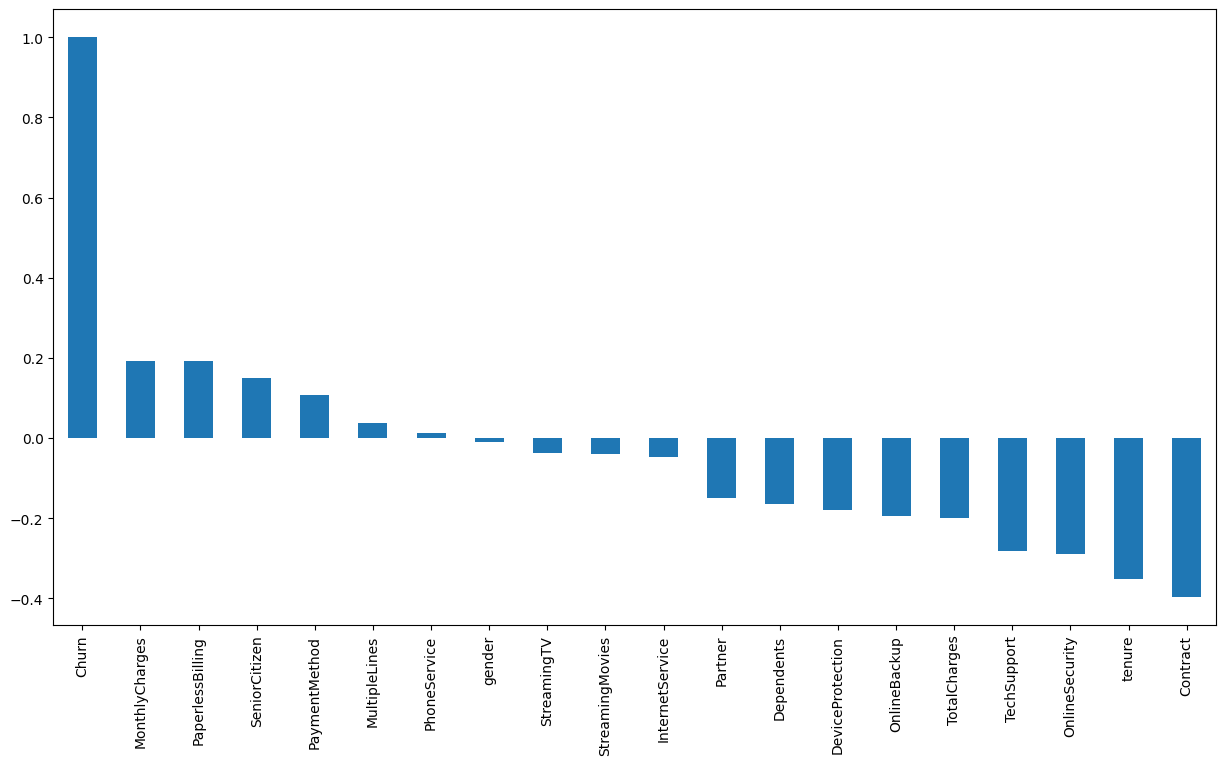

In [46]:
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

<Axes: >

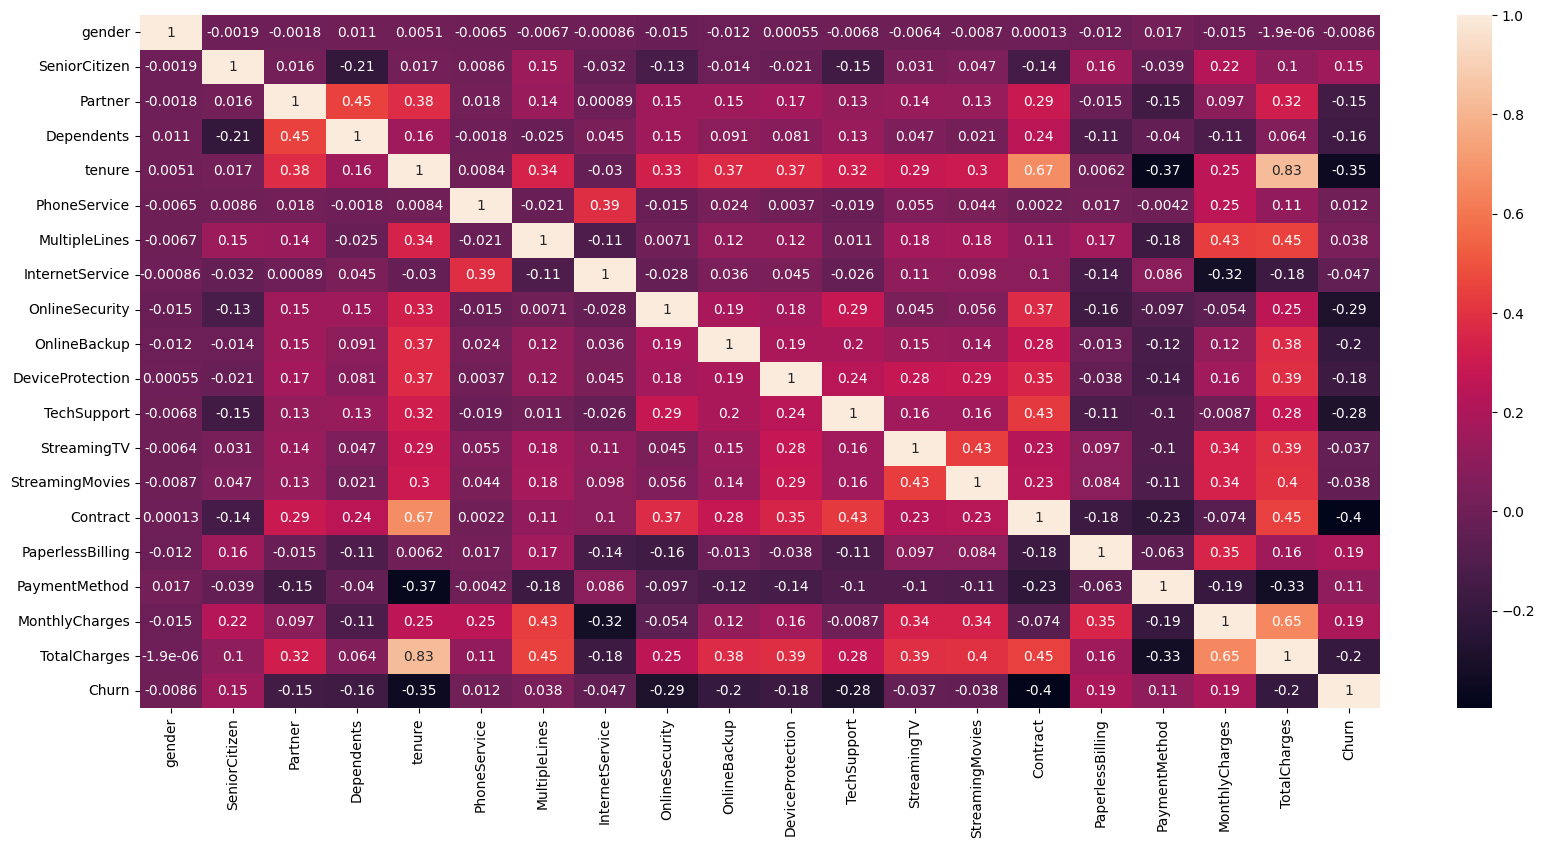

In [47]:
# Finding the correlation between the independent and dependent feature
plt.figure(figsize=(20, 9))
sns.heatmap(df.corr(), annot=True)

I am using ensemble methods, No need to perform feature scaling for ensemble techniques, its prediction based on the creating multiple decision trees

#### Splitting the dataset into train and test

In [48]:
# splitting dataset into dependent and independent feature
X = df.drop(columns='Churn')
y = df['Churn']

In [50]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65


#### Feature Selection:
     Selects only 10 feature which has higher correlation

In [51]:
# selects the feature which has more correlation
selection = SelectKBest()  # k=10 default
X = selection.fit_transform(X,y)

In [52]:
#  this will shows which feature are taken denote as True other are removed like false
selection.get_support()

array([False, False, False,  True,  True, False, False, False,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True])

**According to the feature selection, we selects the 10 out of 21 features. these are the 10 features are selected [Dependents, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges, TotalCharges]**

##### **From sklearn using feature selection modules importing the SelectKBest to select the important feature**

In [53]:
# splitting for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [54]:
X_train.shape

(5634, 10)

In [55]:
X_test.shape

(1409, 10)

In [56]:
# its an imbalance dataset
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

#### **Apply into machine learning algorithm:**

In [57]:
Log_reg = LogisticRegression(C=150, max_iter=150)
Log_reg.fit(X_train, y_train)
log_pred = Log_reg.predict(X_test)

print(f'Accuracy score : {accuracy_score(log_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(log_pred, y_test)}')
print(f'Classification report :\n {classification_report(log_pred, y_test)}')

Accuracy score : 0.7913413768630234
Confusion matrix :
 [[931 177]
 [117 184]]
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      1108
           1       0.51      0.61      0.56       301

    accuracy                           0.79      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.81      0.79      0.80      1409



In [58]:
# Random forest classifier
Rfc = RandomForestClassifier(n_estimators=120,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=5)
Rfc.fit(X_train, y_train)
rfc_pred = Rfc.predict(X_test)

print(f'Accuracy score : {accuracy_score(rfc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_pred, y_test)}')
print(f'Classification report :\n {classification_report(rfc_pred, y_test)}')

Accuracy score : 0.7970191625266146
Confusion matrix :
 [[958 196]
 [ 90 165]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      1154
           1       0.46      0.65      0.54       255

    accuracy                           0.80      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.83      0.80      0.81      1409



In [59]:
# decisionTree Classifier
Dtc = DecisionTreeClassifier(criterion='gini', splitter='random', min_samples_leaf=15)
Dtc.fit(X_train, y_train)
dtc_pred = Dtc.predict(X_test)

print(f'Accuracy score : {accuracy_score(dtc_pred, y_test)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_pred, y_test)}')
print(f'Classification report :\n {classification_report(dtc_pred, y_test)}')

Accuracy score : 0.7885024840312278
Confusion matrix :
 [[956 206]
 [ 92 155]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.82      0.87      1162
           1       0.43      0.63      0.51       247

    accuracy                           0.79      1409
   macro avg       0.67      0.73      0.69      1409
weighted avg       0.83      0.79      0.80      1409



**As we compare to the imbalance dataset our model are perform like okay not a better model to build for end to end project. So we need to over smpling data for reducing the TN, FN and increase the FP and TP for model building**

### **Using SMOTEENN for imbalance dataset:**
     Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours

In [60]:
st=SMOTEENN()
X_train_st,y_train_st = st.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 4126, 1: 1508})
The number of classes after fit Counter({1: 2382, 0: 2118})


In [61]:
# splitting the over sampling dataset
X_train_sap, X_test_sap, y_train_sap, y_test_sap = train_test_split(X_train_st, y_train_st, test_size=0.2)

In [62]:
# decisionTree Classifier
Dtc_sampling = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=7, min_samples_leaf=15)
Dtc_sampling.fit(X_train_sap, y_train_sap)
dtc_sampling_pred = Dtc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(dtc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(dtc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(dtc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9222222222222223
Confusion matrix :
 [[402  35]
 [ 35 428]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       437
           1       0.92      0.92      0.92       463

    accuracy                           0.92       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.92      0.92      0.92       900



In [63]:
# Random forest classifier
Rfc_sampling = RandomForestClassifier(n_estimators=150,criterion='gini', max_depth=15, min_samples_leaf=10, min_samples_split=6)
Rfc_sampling.fit(X_train_sap, y_train_sap)
rfc_sampling_pred = Rfc_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(rfc_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(rfc_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(rfc_sampling_pred, y_test_sap)}')

Accuracy score : 0.9322222222222222
Confusion matrix :
 [[400  24]
 [ 37 439]]
Classification report :
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       424
           1       0.95      0.92      0.94       476

    accuracy                           0.93       900
   macro avg       0.93      0.93      0.93       900
weighted avg       0.93      0.93      0.93       900



In [64]:
# logistic regression
Log_reg_sampling = LogisticRegression(C=10, max_iter=150)
Log_reg_sampling.fit(X_train_sap, y_train_sap)
Log_sampling_pred = Log_reg_sampling.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(Log_sampling_pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(Log_sampling_pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(Log_sampling_pred, y_test_sap)}')

Accuracy score : 0.9188888888888889
Confusion matrix :
 [[391  27]
 [ 46 436]]
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       418
           1       0.94      0.90      0.92       482

    accuracy                           0.92       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.92      0.92      0.92       900



In [65]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sap, y_train_sap)
pred = gbc.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9444444444444444
Confusion matrix :
 [[408  21]
 [ 29 442]]
Classification report :
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       429
           1       0.95      0.94      0.95       471

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



**After using SMOOTEENN methods to perform over sampling and down sampling with edited nearest neighbours. From this results we get bet accuraccy and TP FP ratio also increases in GradientBoostClassifier so perform HyperParameter Tunning for this model only**

In [66]:
param_grid = {'n_estimators':[100, 150, 200, 250, 300],
             'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
             'min_samples_split': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf': [1,3,5,7,9,11,13,15],'max_leaf_nodes': [3,6,8,9,12,15,18,24],
              'max_depth': [3,5,7,9,11,13,15,17,19],
              'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'loss': ['deviance', 'exponential']
              }

In [67]:
gbc_optm = RandomizedSearchCV(estimator=gbc, param_distributions=param_grid,n_iter=100, verbose=3)
gbc_optm.fit(X_train_sap, y_train_sap)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END criterion=mse, learning_rate=0.2, loss=deviance, max_depth=19, max_leaf_nodes=24, min_samples_leaf=9, min_samples_split=3, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END crit

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [3, 5, 7, 9, 11, 13, 15,
                                                      17, 19],
                                        'max_leaf_nodes': [3, 6, 8, 9, 12, 15,
                                                           18, 24],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   verbose=3)

In [68]:
gbc_optm.best_estimator_

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.5,
                           loss='exponential', max_depth=11, max_leaf_nodes=15,
                           min_samples_leaf=5, n_estimators=150)

In [69]:
# GradientBoostingClassifier
gbc_tunning = GradientBoostingClassifier(criterion='squared_error', learning_rate=0.3,
                           max_depth=19, max_leaf_nodes=24, min_samples_leaf=9,
                           min_samples_split=7, n_estimators=150)
gbc_tunning.fit(X_train_sap, y_train_sap)
pred = gbc_tunning.predict(X_test_sap)

print(f'Accuracy score : {accuracy_score(pred, y_test_sap)}')
print(f'Confusion matrix :\n {confusion_matrix(pred, y_test_sap)}')
print(f'Classification report :\n {classification_report(pred, y_test_sap)}')

Accuracy score : 0.9577777777777777
Confusion matrix :
 [[410  11]
 [ 27 452]]
Classification report :
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       421
           1       0.98      0.94      0.96       479

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



**After Oversampling the dataset our model performs is pretty good. From our 4 model GradientBoostClassifier performs better than all. So we dumb our model using pickle library**

#### **Model Saving:**

In [70]:
import pickle

In [71]:
filename = 'Model.sav'
pickle.dump(gbc_tunning, open(filename,'wb'))

In [72]:
load_model = pickle.load(open(filename, 'rb'))

In [73]:
load_model.score(X_test_sap, y_test_sap)

0.9577777777777777

In [74]:
Dependents = 'Yes'
tenure = 1
OnlineSecurity = 'No'
OnlineBackup = 'Yes'
DeviceProtection = 'No'
TechSupport = 'No'
Contract = 'Month-to-month'
PaperlessBilling = 'No'
MonthlyCharges = 29.85
TotalCharges = 556.85

In [75]:
data = [[Dependents, tenure, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges, TotalCharges]]

In [76]:
df = pd.DataFrame(data, columns=['Dependents', 'tenure', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
        'PaperlessBilling', 'MonthlyCharges', 'TotalCharges'])
df.head()
print(df.dtypes)

Dependents           object
tenure                int64
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
MonthlyCharges      float64
TotalCharges        float64
dtype: object


In [77]:
for feature in df.columns:
    if df[feature].dtypes == 'O':
        categorical_feature = feature
        print(categorical_feature)

Dependents
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
Contract
PaperlessBilling


In [78]:
encoder = LabelEncoder()
for feature in df.columns:
    if df[feature].dtypes == 'O':
        df[feature] = encoder.fit_transform(df[feature])

In [79]:
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,TotalCharges
0,0,1,0,0,0,0,0,0,29.85,556.85


In [80]:
single = load_model.predict(df)
probability = load_model.predict_proba(df)[:,1]

In [81]:
print(single)

[0]


In [82]:
print(probability)

[0.08717364]


In [83]:
if single == 1:
    print("This Customer is likely to be Churned!")
    print(f"Confidence level is {np.round(probability*100, 2)}")
else:
    print("This Customer is likely to be Continue!")
    print(f"Confidence level is {np.round(probability*100, 2)}")

This Customer is likely to be Continue!
Confidence level is [8.72]
